### Описание проекта.

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### План (для предварительной итерации).

Решаем задачу регресии, соответственно, необходимо выделить признаки для обучения модели и целевой признак.

Проведем загрузку данных, EDA, составим план дальнейшей работы, список вопросов.

### Импорт библиотек.

In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

### Настройки(а).

In [2]:
sns.set_theme()

### Константы.

In [3]:
PATH = '/datasets/final_steel/'
RS = 270123
CV = KFold(n_splits = 3, shuffle = True, random_state = RS)
SCORER = 'neg_mean_absolute_error'

### Загрузка данных и предобработка.

Датафреймы удобнее будет загружать по одному, чтобы не перезапускать всю тетрадь при работе с отдельным датафреймом. В конце сформулируем общие выводы и т.д.

#### data_arc:

In [4]:
try:
    data_arc = pd.read_csv('data_arc.csv')
except:
    data_arc = pd.read_csv(PATH + 'data_arc.csv')

Выведем инфо.

In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Пропуски отсутствуют, необходимо привести столбцы к типу дата / время.

Одному ключу соответствуют несколько строк данных, упорядоченных по возрастанию времени.

Проверим выбросы / аномалии.

In [7]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


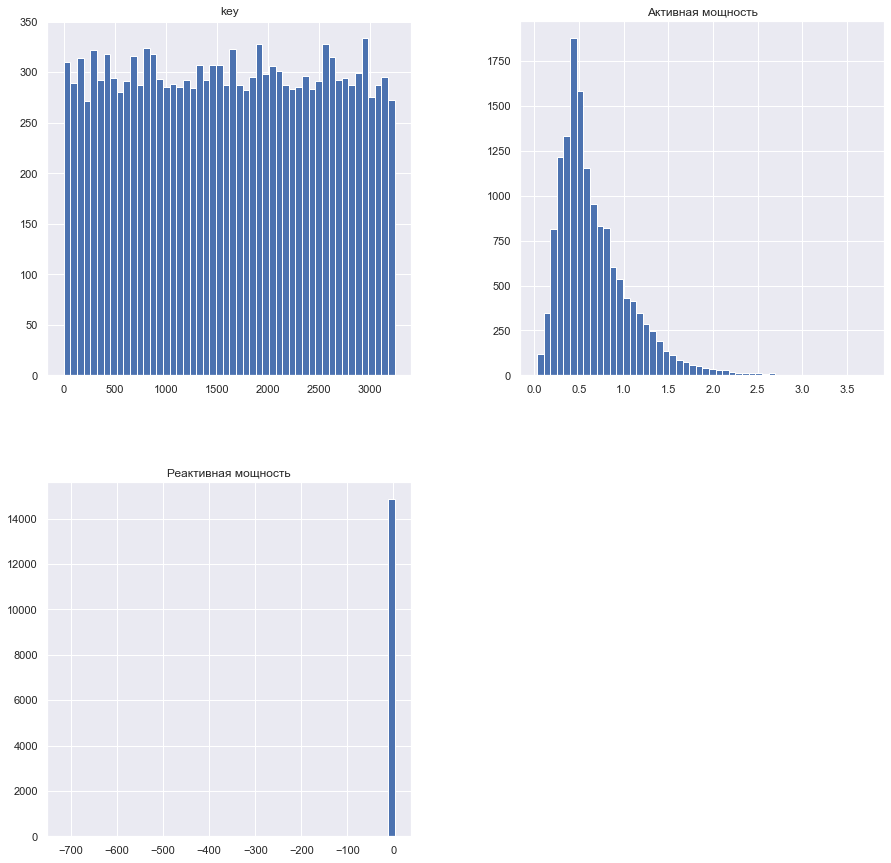

In [8]:
data_arc.hist(bins = 50, figsize = (15, 15))
plt.show()

Необходимо обработать отрицательные значения мощности.

#### data_bulk:

In [9]:
try:
    data_bulk = pd.read_csv('data_bulk.csv')
except:
    data_bulk = pd.read_csv(PATH + 'data_bulk.csv')

Инфо и сэмпл.

In [10]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [11]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Очевидная проблема датафрейма - обильное наличие пропусков. Оптимальной стратегией будет заполнение нулевыми значениями - пропуски означают отсутствие подачи материала в конкретной точке.

Данные развернуты "в ширину" - уникальному ключу соответствует единственная строка, содержащая данные о разных этапах подачи материала.

Изучим выбросы.

In [12]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Выведем гистограмму.

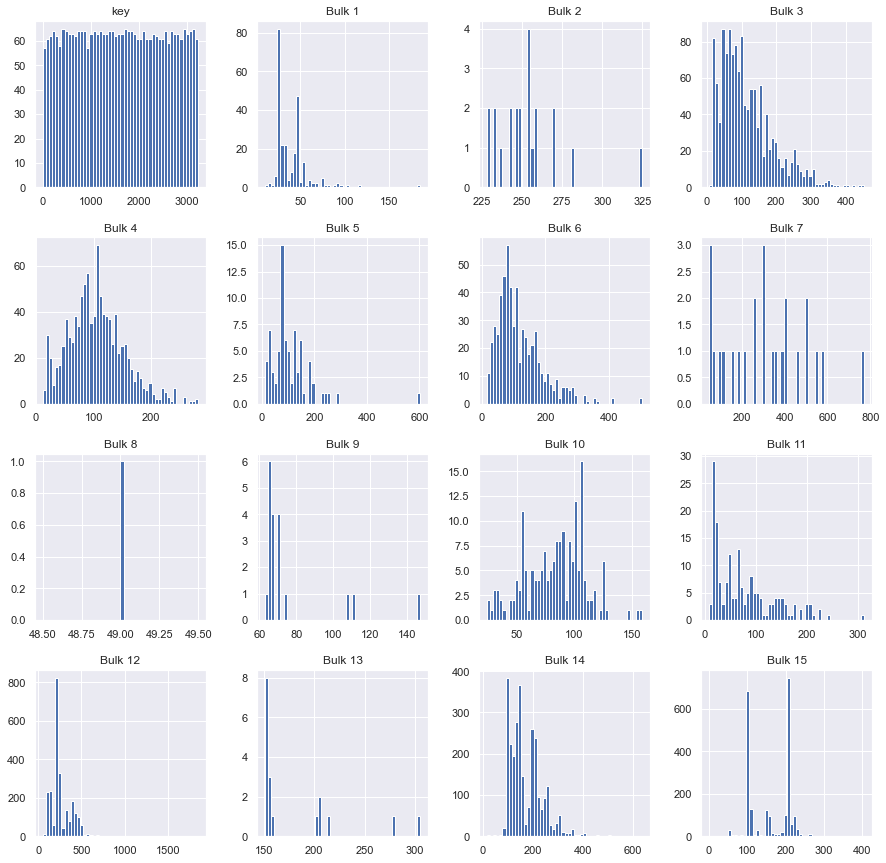

In [13]:
data_bulk.hist(bins = 50, figsize = (15, 15))
plt.show()

Выбросы имеются в большом количестве столбцов. В Bulk 8 единственное значение.

Обращает внимание, что два вышеприведенных датафрейма имеют различную ориентацию. Ниже попробуем проанализировать, каким образом организовать работу, чтобы можно было корректно совместить данные.

#### data_bulk_time:

In [14]:
try:
    data_bulk_time = pd.read_csv('data_bulk_time.csv')
except:
    data_bulk_time = pd.read_csv(PATH + 'data_bulk_time.csv')

In [15]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [16]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Видим значения даты к предыдущему датафрейму, соответственно большое количество пропусков.

#### data_gas:

In [17]:
try:
    data_gas = pd.read_csv('data_gas.csv')
except:
    data_gas = pd.read_csv(PATH + 'data_gas.csv')

In [18]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [19]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Пропуски отсутствуют, для каждого ключа имеется единственное значение показателя.

In [20]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


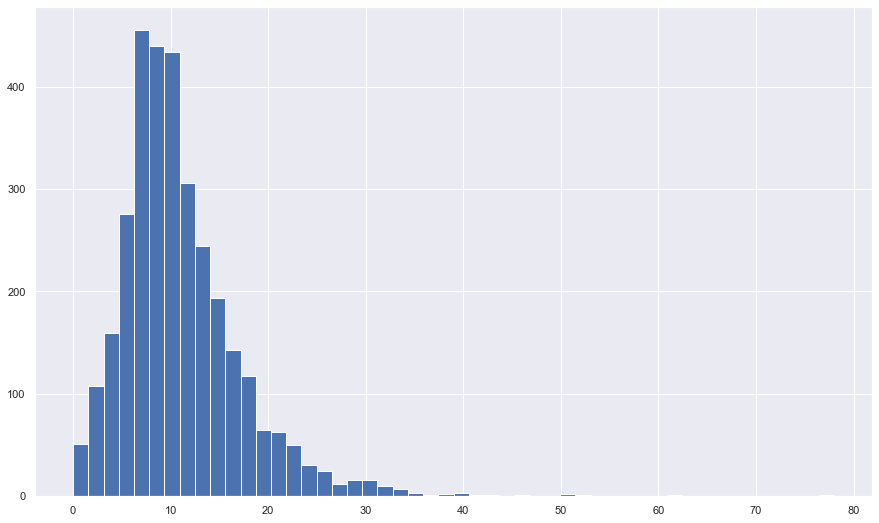

In [21]:
data_gas['Газ 1'].hist(bins = 50, figsize = (15, 9))
plt.show()

Видим наличие выбросов.

#### data_temp:

In [22]:
try:
    data_temp = pd.read_csv('data_temp.csv')
except:
    data_temp = pd.read_csv(PATH + 'data_temp.csv')

In [23]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [24]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Датафрейм с целевой метрикой температуры. Организован, как первый датафрейм. Для каждого ключа имеются несколько строк данных, отсортированных по возрастанию времени измерения.

Имеются пропуски данных.

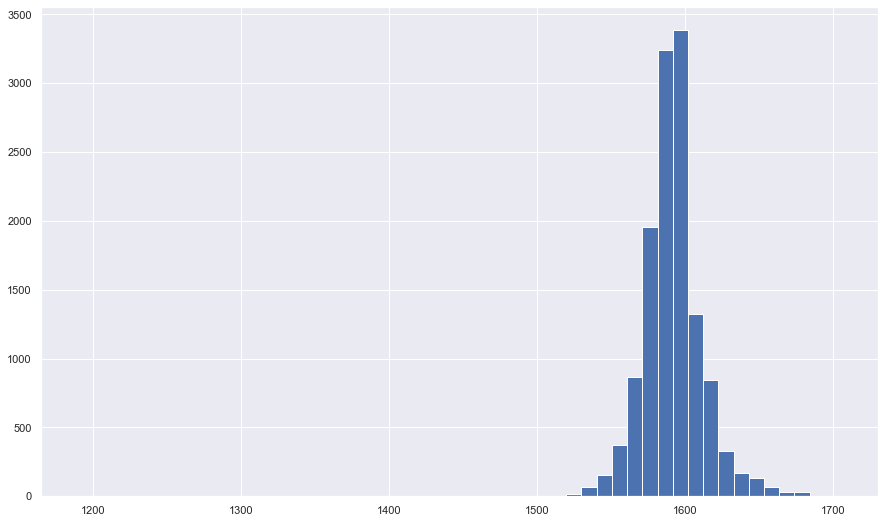

In [25]:
data_temp['Температура'].hist(bins = 50, figsize = (15, 9))
plt.show()

Распределение выглядит довольно симметричным, но имеются аномально низкие значения ниже среднего.

#### data_wire:

In [26]:
try:
    data_wire = pd.read_csv('data_wire.csv')
except:
    data_wire = pd.read_csv(PATH + 'data_wire.csv')

In [27]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [28]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Датафрейм с данными о подаче проволочного материала.

Имеются попуски, которые могут быть заполнены нулями.

In [29]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


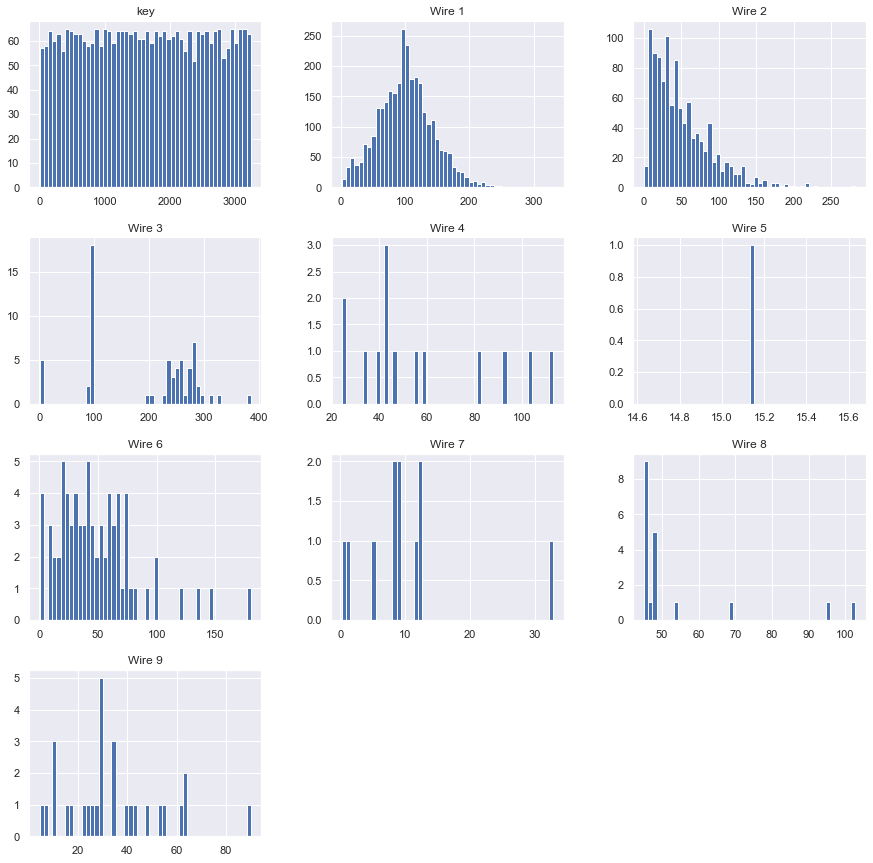

In [30]:
data_wire.hist(bins = 50, figsize = (15, 15))
plt.show()

Имеется некоторое количество выбросов, столбец wire 5 содержит единственное значение.

#### data_wire_time:

In [31]:
try:
    data_wire_time = pd.read_csv('data_wire_time.csv')
except:
    data_wire_time = pd.read_csv(PATH + 'data_wire_time.csv')

In [32]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [33]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Датафрейм содержащий сведения о времени подачи проволочного материала.

### Предварительные выводы:

Итак, согласно описанию задачи, на вход подается сталь, которая несколько раз нагревается электродами и в состав добавляются легирующие добавки. Нагрев и легирование могут повторяться несколько раз до достижения оптимальной температуры плавления. Таким образом, оптимальная температура указана в последней строке для каждого уникального ключа в соответствующем датафрейме.

Данные собраны в нескольких датафреймах и организованы тремя различными способами: а) каждому ключу соответствуют несколько строк, упорядоченных по времени измерения, б) одному ключу соответствует одна строка, содержащая несколько разных признаков (в датафреймах со сведениями о легирующих добавках) и в) одному ключу соответствует одна строка с единственным признаком.

Целевой признак содержится в последней строке с измерениями для каждого уникального ключа, таким образом, данные могут быть собраны в датафрейм, где каждому ключу будет соответствовать единственная строка.

Согласно условию, состав продувается газом на при каждой подаче добавок, однако датафрейм содержит единственное значение, видимо, суммарное. Кроме того, отсутствует время подачи газа. При предложенном выше способе время подачи добавок существенной роли не играет и данные датафреймов data_bulk_time и data_wire_time могут быть пропущены.

Чтобы получить единственную строку для каждого ключа, данные по нагреву предлагаю просуммировать.

## План проекта
**1. Проведение обзора данных (EDA)**

**Подготовка данных:** 
* Импорт необходимых библиотек;
* Чтение файлов и сохранение полученных данных в переменные;
* Получение общей информации о таблицах (head, info, describe);
* Корректировка наименований столбцов (при необходимости).
* Выводы

**Анализ данных:**
* Графическое представление данных из таблиц;
* Проверка данных на аномалии.
* Выводы

**Предобработка данных:**
* Корректировка типов данных (при необходимости);
* Заполнение пропусков / удаление дубликатов (при наличии);
* Выделение признаков и таргета;
* Соединение таблиц.
* Выводы

**Исследование итоговой таблицы с данными:**
* Аналитический анализ
* графический анализ
* корреляционный анализ
* выводы

**2. Построение модели машинного обучения**

**Обучение модели:**
* Разделение данных на обучающую и тестовую выборки;
* Масштабирование данных;
* Обучение модели линейной регрессии;
* Обучение модели градиентного бустинга с перебором гиперпараметров;
* Константная модели.
* Выбор лучшей модели

**Проверка моделей:**
* Тестирование лучшей модели на тестовой выборке;
* Если MAE на тестовых данных > 6.8 - доработка модели.
* Анализ важности факторов

**3. Общий вывод**

### Соберем новый датафрейм.

#### Проведем необходимые преобразования data_arc

In [34]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Выше отмечали, что необходимо обработать отрицательные значения реактивной мощности.

In [35]:
data_arc[data_arc['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Также проверим дубликаты.

In [36]:
data_arc.duplicated().sum()

0

Приведем столбцы к типу дата / время, вычислим продолжительность нагрева.

In [37]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

In [38]:
data_arc['Продолжительность нагрева'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']

Проведем группировку по ключу, просуммируем значения столбцов для каждого ключа.

In [39]:
da_grouped = data_arc.groupby('key').agg({'Продолжительность нагрева': 'sum', 'Активная мощность': 'sum',
                                          'Реактивная мощность': 'sum'})

In [40]:
da_grouped.head()

,Продолжительность нагрева,Активная мощность,Реактивная мощность
key,,,
1,0 days 00:18:18,4.878147,3.183241
2,0 days 00:13:31,3.052598,1.998112
3,0 days 00:10:55,2.525882,1.599076
4,0 days 00:12:21,3.209250,2.060298
5,0 days 00:14:29,3.347173,2.252643


In [41]:
da_grouped.drop(2116, inplace = True)

In [42]:
da_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 1 to 3241
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   Продолжительность нагрева  3213 non-null   timedelta64[ns]
 1   Активная мощность          3213 non-null   float64        
 2   Реактивная мощность        3213 non-null   float64        
dtypes: float64(2), timedelta64[ns](1)
memory usage: 100.4 KB


Продолжим предобработку:

продолжительность приведем к типу float (переведем в минуты),

показатели мощности сильно коррелированы: высчитаем показатель полной мощности,

высчитаем показатель работы перемножив мощность на время

In [43]:
da_grouped['hours_to_minutes'] = da_grouped['Продолжительность нагрева'].dt.components['hours'] * 60
da_grouped['minutes'] = da_grouped['Продолжительность нагрева'].dt.components['minutes']
da_grouped['seconds_to_minutes'] = da_grouped['Продолжительность нагрева'].dt.components['seconds'] / 60
da_grouped['Нагрев'] = da_grouped['hours_to_minutes'] + da_grouped['minutes'] + da_grouped['seconds_to_minutes']

In [44]:
da_grouped.drop(['Продолжительность нагрева', 'hours_to_minutes', 'minutes', 'seconds_to_minutes'],
                axis = 1, inplace = True)

In [45]:
da_grouped['Полная мощность'] = da_grouped['Активная мощность']**2 + da_grouped['Реактивная мощность']**2

In [46]:
da_grouped['Полная мощность'] = da_grouped['Полная мощность']**0.5

In [47]:
da_grouped['Работа'] = da_grouped['Полная мощность'] * da_grouped['Нагрев']

In [48]:
da_grouped.drop(['Активная мощность', 'Реактивная мощность', 'Полная мощность', 'Нагрев'],
                axis = 1, inplace = True)

Также логарифмируем значение показателя (улучшит метрику линейной регресии на пару сотых)

In [49]:
da_grouped = np.log(da_grouped)

Гистограммы

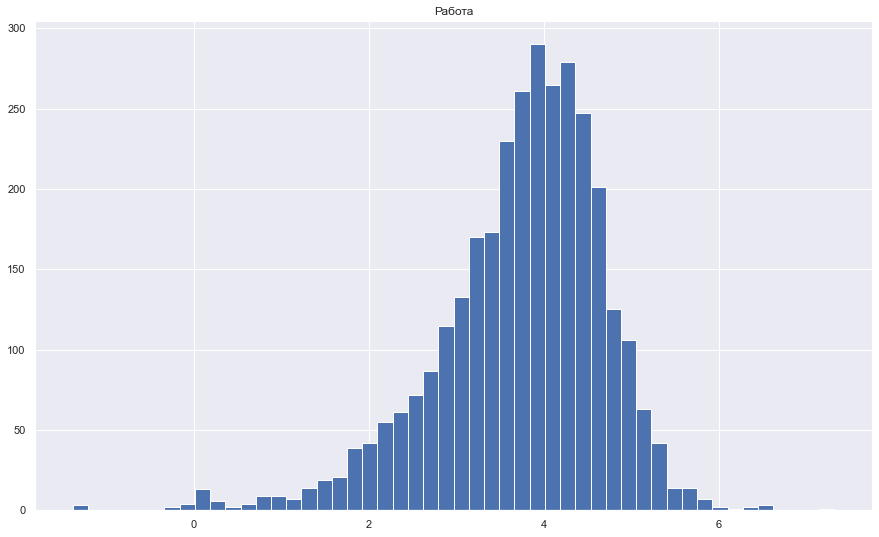

In [50]:
da_grouped.hist(bins = 50, figsize = (15, 9))
plt.show()

Вполне удобоваримо. Переходим дальше.

#### data_bulk.

В data_bulk необходимо заполнить нулями пропуски и установить значения колонки 'key' в качестве индекса.

In [51]:
data_bulk = data_bulk.fillna(0)

In [52]:
data_bulk.set_index('key', drop = True, inplace = True)

In [53]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Bulk 1   3129 non-null   float64
 1   Bulk 2   3129 non-null   float64
 2   Bulk 3   3129 non-null   float64
 3   Bulk 4   3129 non-null   float64
 4   Bulk 5   3129 non-null   float64
 5   Bulk 6   3129 non-null   float64
 6   Bulk 7   3129 non-null   float64
 7   Bulk 8   3129 non-null   float64
 8   Bulk 9   3129 non-null   float64
 9   Bulk 10  3129 non-null   float64
 10  Bulk 11  3129 non-null   float64
 11  Bulk 12  3129 non-null   float64
 12  Bulk 13  3129 non-null   float64
 13  Bulk 14  3129 non-null   float64
 14  Bulk 15  3129 non-null   float64
dtypes: float64(15)
memory usage: 391.1 KB


In [54]:
data_bulk.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


#### data_gas

В data_gas также установим индекс по ключу.

In [55]:
data_gas.set_index('key', drop = True, inplace = True)

In [56]:
data_gas.head()

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


In [57]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Газ 1   3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


In [58]:
data_gas = np.log(data_gas)

#### data_temp

Проведем группировку по ключу, для каждого ключа выделим температуру перед началом процесса, как фичу и последнее значение температуры как таргет.

In [59]:
keys_list = list(data_temp['key'].unique())

In [60]:
for key in keys_list:
    data_temp.loc[data_temp['key'] == key, 'Темп начала'] = \
    data_temp.loc[data_temp[data_temp['key'] == key].index.min(), 'Температура']
    data_temp.loc[data_temp['key'] == key, 'Темп оптим'] = \
    data_temp.loc[data_temp[data_temp['key'] == key].index.max(), 'Температура']

In [61]:
data_temp

,key,Время замера,Температура,Темп начала,Темп оптим
0,1,2019-05-03 11:16:18,1571.0,1571.0,1613.0
1,1,2019-05-03 11:25:53,1604.0,1571.0,1613.0
2,1,2019-05-03 11:29:11,1618.0,1571.0,1613.0
3,1,2019-05-03 11:30:01,1601.0,1571.0,1613.0
4,1,2019-05-03 11:30:39,1613.0,1571.0,1613.0
...,...,...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0,1586.0,NaN
15903,3241,2019-09-01 04:16:12,NaN,1586.0,NaN
15904,3241,2019-09-01 04:22:39,NaN,1586.0,NaN
15905,3241,2019-09-01 04:33:42,NaN,1586.0,NaN


In [62]:
dt_agg = data_temp.groupby('key').agg({'Темп начала': 'mean', 'Темп оптим': 'mean'})

Большое количество пропусков в целевом признаке. Придется удалять.

In [63]:
dt_agg = dt_agg.dropna()

In [64]:
dt_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Темп начала  2477 non-null   float64
 1   Темп оптим   2477 non-null   float64
dtypes: float64(2)
memory usage: 58.1 KB


In [65]:
dt_agg

,Темп начала,Темп оптим
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


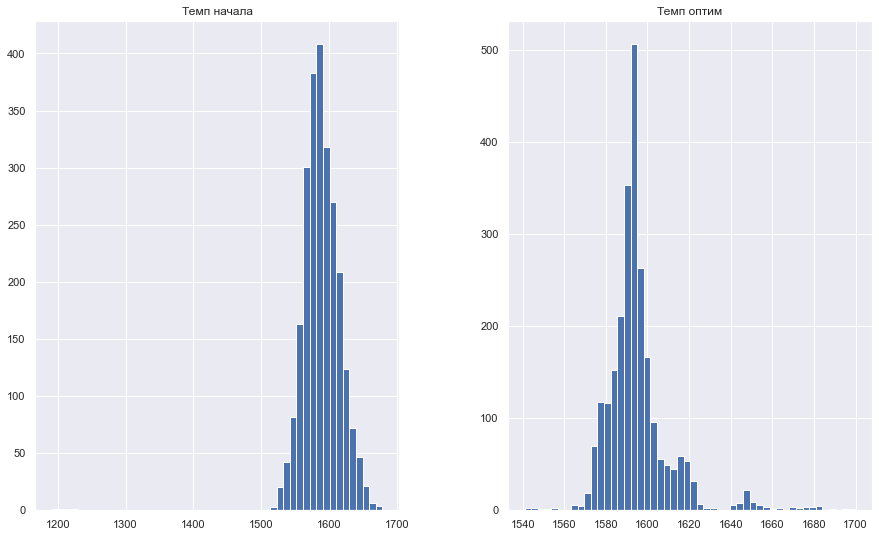

In [66]:
dt_agg.hist(bins = 50, figsize = (15, 9))
plt.show()

"Выброс", который нашли ранее попал в температуру до начала плавления, что вполне объяснимо. Таким образом, удалять нет необходимости. В целевом признаке выбросов не наблюдаем.

#### data_wire:

Установим "key"  в качестве индекса, заполним пропуски нулями.

In [67]:
data_wire = data_wire.fillna(0)

In [68]:
data_wire.set_index('key', drop = True, inplace = True)

In [69]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Wire 1  3081 non-null   float64
 1   Wire 2  3081 non-null   float64
 2   Wire 3  3081 non-null   float64
 3   Wire 4  3081 non-null   float64
 4   Wire 5  3081 non-null   float64
 5   Wire 6  3081 non-null   float64
 6   Wire 7  3081 non-null   float64
 7   Wire 8  3081 non-null   float64
 8   Wire 9  3081 non-null   float64
dtypes: float64(9)
memory usage: 240.7 KB


In [70]:
data_wire.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Объединяем в один датафрейм.

In [71]:
df = da_grouped.join([data_bulk, data_gas, data_wire, dt_agg], how = 'inner')

Тип джойна выбираем 'inner', чтобы в итоговый датафрейм попали только те строки (ключи), по которым содержатся все доступные значения как фичей, так и таргета. 

In [72]:
df.reset_index(drop = True, inplace=True)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Работа       2328 non-null   float64
 1   Bulk 1       2328 non-null   float64
 2   Bulk 2       2328 non-null   float64
 3   Bulk 3       2328 non-null   float64
 4   Bulk 4       2328 non-null   float64
 5   Bulk 5       2328 non-null   float64
 6   Bulk 6       2328 non-null   float64
 7   Bulk 7       2328 non-null   float64
 8   Bulk 8       2328 non-null   float64
 9   Bulk 9       2328 non-null   float64
 10  Bulk 10      2328 non-null   float64
 11  Bulk 11      2328 non-null   float64
 12  Bulk 12      2328 non-null   float64
 13  Bulk 13      2328 non-null   float64
 14  Bulk 14      2328 non-null   float64
 15  Bulk 15      2328 non-null   float64
 16  Газ 1        2328 non-null   float64
 17  Wire 1       2328 non-null   float64
 18  Wire 2       2328 non-null   float64
 19  Wire 3

In [74]:
df

,Работа,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Темп начала,Темп оптим
0,4.669041,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1613.0
1,3.898212,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1581.0,1602.0
2,3.485398,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,1599.0
3,3.852249,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1601.0,1625.0
4,4.067905,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,3.871651,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1570.0,1591.0
2324,4.372106,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1554.0,1591.0
2325,3.308976,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,...,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1589.0
2326,3.947236,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1591.0,1594.0


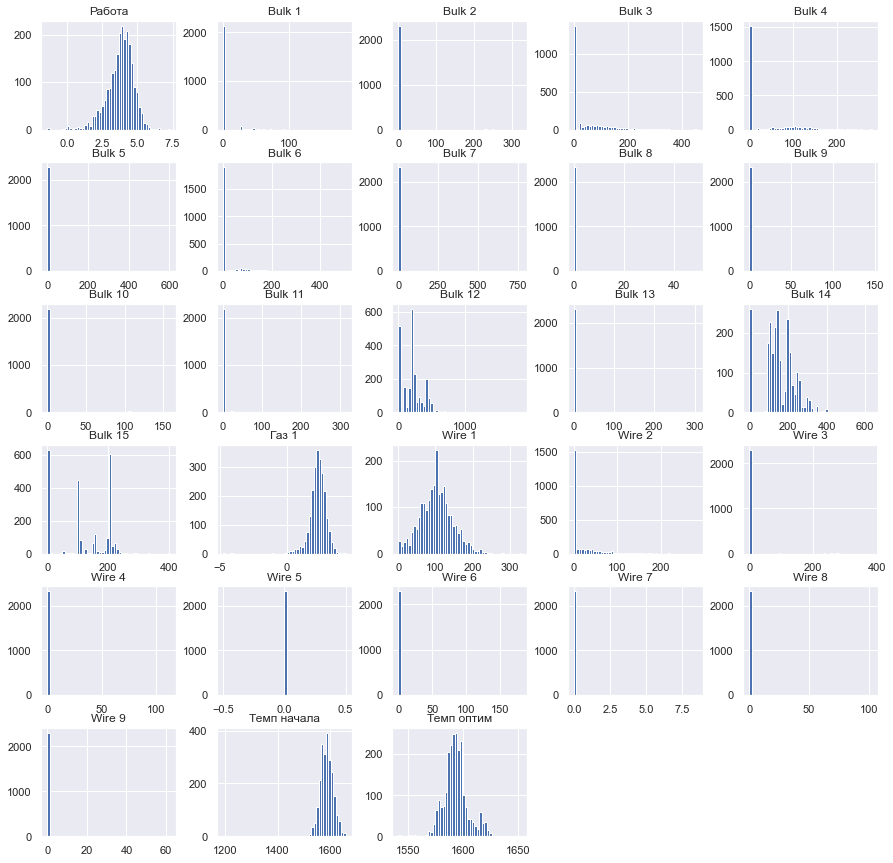

In [75]:
df.hist(bins = 50, figsize = (15, 15))
plt.show()

Проверим на мультиколлинеарность признаков.

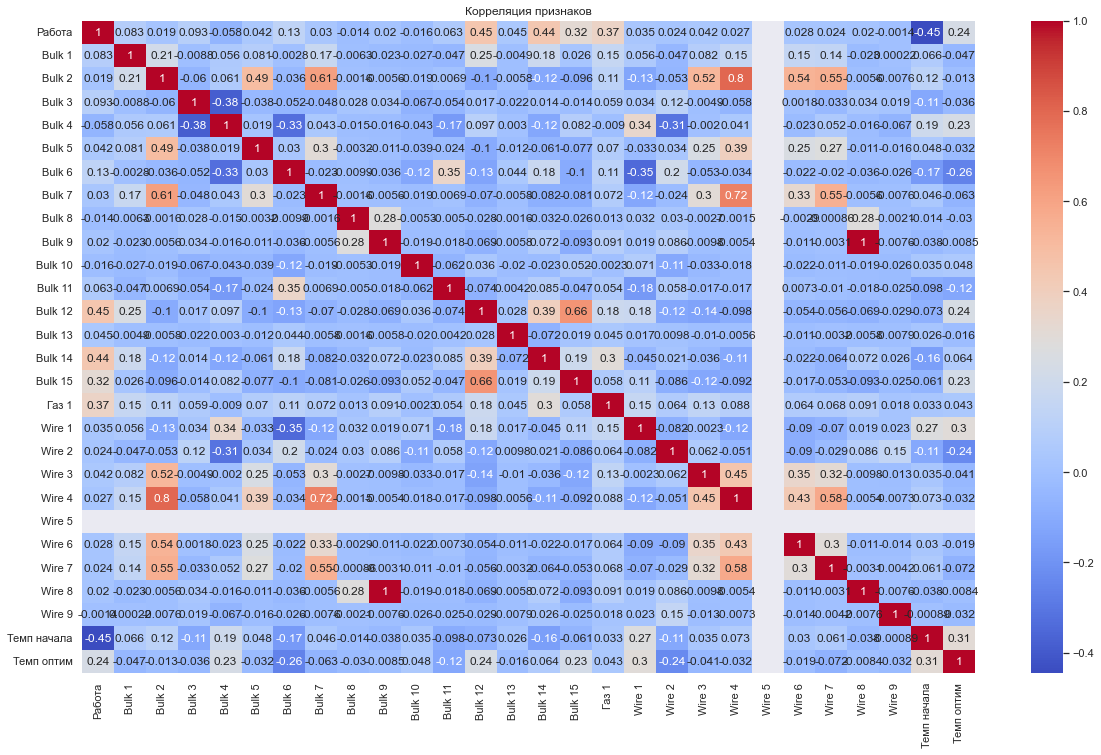

In [76]:
plt.figure(figsize=(20, 12))
plt.title('Корреляция признаков')
sns.heatmap(df.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

Удалим столбцы с корреляцией выше 0.7 (так совпадает в нашем конкретном случае из за Wire 4). Wire 4 коррелирует сразу с двумя столбцами, Wire 8 коррелирует с Bulk 9. Wire 5 не очень понятно что именно происходит, но тоже удалим.

In [77]:
df.drop(['Wire 4', 'Wire 8', 'Wire 5'], axis = 1, inplace = True)

### Перейдем к обучению моделей.

#### Выделим целевой признак.

In [78]:
X = df.drop('Темп оптим', axis = 1)
y = df['Темп оптим']

#### Разобьем выборку на обучающую и тестовую.

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RS)

In [80]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1862, 24), (466, 24), (1862,), (466,))

#### Dummy модель.

In [81]:
dr_score = cross_val_score(DummyRegressor(), X_train, y_train, cv = CV, scoring = SCORER)

In [82]:
-dr_score.mean()

8.03136059517013

#### Модель линейной регрессии.

In [83]:
lr_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                          ('estimator', LinearRegression())])

In [84]:
lr_cv = cross_validate(lr_pipe, X_train, y_train, cv = CV, scoring = SCORER,
                       return_estimator = True, n_jobs = -1)

In [85]:
lr_cv['test_score']

array([-6.4708073 , -6.86014091, -7.32403675])

In [86]:
-lr_cv['test_score'].mean()

6.884994987990962

#### Модель градиентного бустинга

In [87]:
gb_pipe = Pipeline(steps=[('preprocessor', StandardScaler()),
                      ('estimator', XGBRegressor(random_state = RS))])

In [88]:
parameters_gb = {
    'estimator__learning_rate': [0.1, 0.2, 0.3],
    'estimator__max_depth': [1, 2, 3],
    'estimator__n_estimators': [100, 110, 120]
}

In [89]:
gb_gs = GridSearchCV(gb_pipe, parameters_gb, cv = CV, scoring = SCORER, n_jobs = -1)

In [90]:
gb_gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=270123, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor', StandardScaler()),
                                       ('estimator',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=Non...
                                                     max_depth

In [91]:
gb_gs.best_estimator_

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('estimator',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='', learning_rate=0.2,
                              max_bin=256, max_cat_threshold=64,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=2, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=110, n_jobs=0, num_parallel_tree=1,
                              p

In [92]:
-gb_gs.best_score_

6.112912613001435

#### Рассмотрим остатки модели градиентного бустинга.

In [93]:
train_preds = gb_gs.best_estimator_.predict(X_train)

In [94]:
train_resids = y_train - train_preds

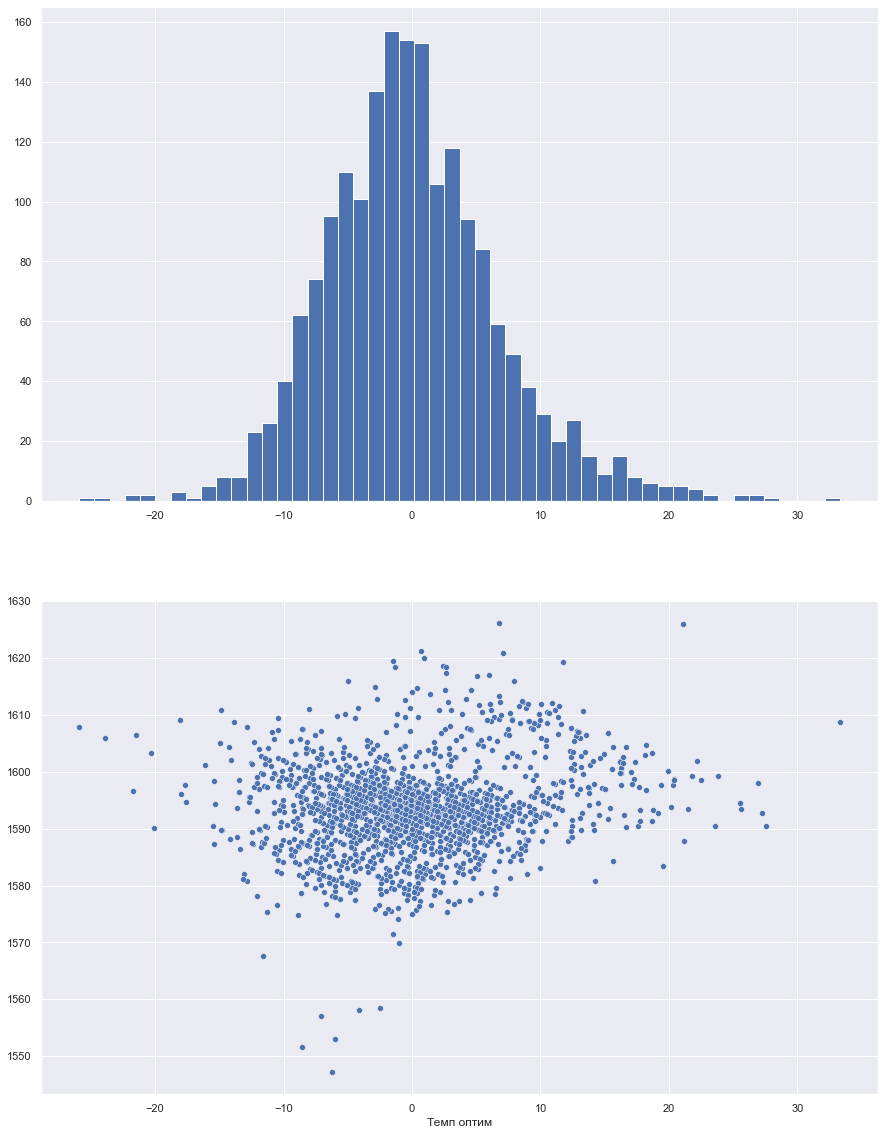

In [95]:
f, ax = plt.subplots(2, figsize = (15, 20))
train_resids.hist(bins = 50, ax = ax[0])
sns.scatterplot(x = train_resids, y = train_preds, ax = ax[1])
plt.show()

Красота)

### Перейдем к тестированию.

#### Метрики градиентного бустинга

In [96]:
gb_preds = gb_gs.best_estimator_.predict(X_test)

In [97]:
mean_absolute_error(gb_preds, y_test)

6.26766561745574

#### Ниже график значимости признаков.

<AxesSubplot:>

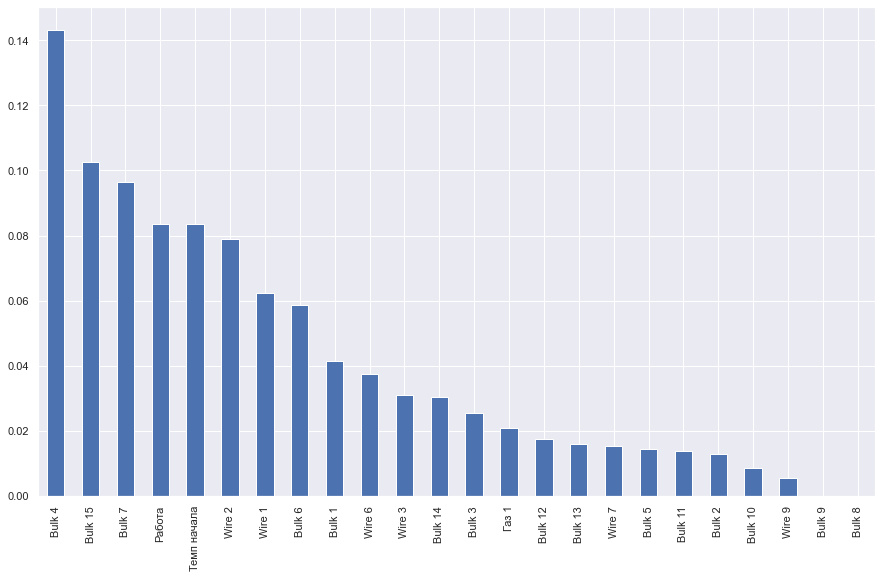

In [98]:
pd.Series(gb_gs.best_estimator_['estimator'].feature_importances_, index = X_train.columns).\
sort_values(ascending = False).\
plot(kind = 'bar', figsize = (15, 9))

# Отчет.

В данном отчете мы постараемся описать процедуру поиска, оптимизации и тестирования модели прогнозирования оптимальной температуры плавления стали методами машинного обучения. Отчет включает в себя описание этапов первичного изучения исходных данных и подготовки плана работ, проведенной предобработки данных, разработки и оптимизации различных моделей, а также итогового тестирования лучшей модели и подготовки выводов на основе проведенной работы.

## Резюме.

Заказчиком поставлена задача разработки модели машинного обучения прогнозирования оптимальной температуры плавления стали в процессе легирования на основе имеющихся данных. Соответственно, решается задача регресии, обучение с учителем.

На входе исследования в нашем распоряжении имелось несколько датафреймов, содержащих результаты измерения различных параметров на разных этапах процесса легирования. В частности, мы располагали данными:
- по времени начала и окончания нагрева и мощности электродов, применяющихся для нагрева стального сплава,
- по объемам различных вводимых легирующих добавок,
- по времени добавления добавок,
- по объему газа, применяемого для продувки сплава,
- данные по температуре до начала нагрева, а также после окончания каждого цикла нагрева.

В качестве метрики моделей была выбрана MAE. Удовлетворительным сочли порог MAE не более 6,8. Нами было проведено исследование исходных данных, проведена необходимая предобработка данных (подробно ниже), данные собраны в один датафрейм для последующей работы.

В частности, показатели первого датафрейма были аггрегированы в единый показатель "работа" путем нахождения промежуточных показателей полной мощности и времени продолжительности нагрева и последующего умножения времени на мощность. Из датафрейма с температурами на различных циклах для каждой партии были выбраны показатели температуры до начала цикла нагревания и показатель последней, "оптимальной температуры".

После чего была проведена стандартная обработка пропусков, дубликатов и аномальных значений показателей. В частности, в датафрейме имелись отрицательные значения мощности, которые были удалены.

После того, как данные были объеденены в один датафрейм, мы провели проверку на мультиколлинеарность признаков. Из каждой пары колонок данных, имеющих высокую корреляцию между собой была удалена одна из колонок.
Некоторые колонки данных, содержащие единственное значение также были удалены.

В качестве контроля адекватности моделей мы применили Dummy Regressor из библиотеки sklearn с настройкой по умолчанию предсказания средним значением целевого признака.

Первой моделью стала модель линейной регрессии. Мы применили кросс - валидацию для оценки метрик модели и получили среднюю метрику МАЕ = 6,88, что не являлось удовлетворительным результатом согласно условиям.

Следующей моделью стала модель градиентного бустинга, выбрали XGBoost с параметром booster = gbtree.
Для поиска оптимальных параметров применили GridSearhCV. Оптимальными параметрами стали max_depth=2, n_estimators=110, learning_rate=0.2, прочие параметры применялись по умолчанию.

Также мы провели анализ остатков модели, убудились, что отатки нормально распределены и дисперсия постоянна на всем протяжении модели.

Модель показала метрику МАЕ = 6,27 на тесте.

Кроме того, мы подготовили для заказчика рейтинг значимости признаков модели, график которого приводим ниже.

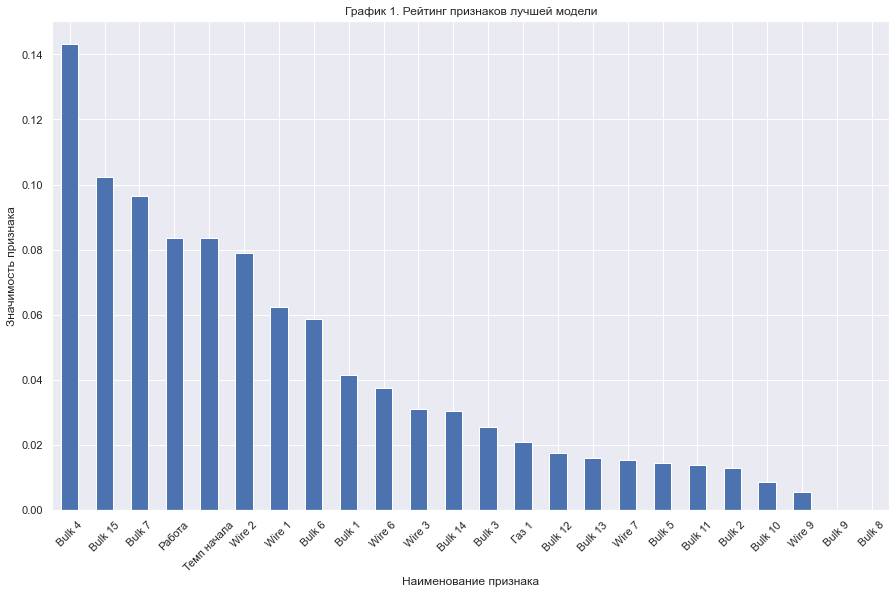

In [101]:
pd.Series(gb_gs.best_estimator_['estimator'].feature_importances_, index = X_train.columns).\
sort_values(ascending = False).\
plot(kind = 'bar', figsize = (15, 9), rot = 45)
plt.title('График 1. Рейтинг признаков лучшей модели')
plt.xlabel('Наименование признака')
plt.ylabel('Значимость признака')
plt.show()

## Обзор исследования исходных данных.

На этом этапе перед нами стояла задача провести первичный анализ исходных данных и подготовить план дальнейшей работы.

Для того, чтобы подготовить модель к обучению, нам необходимо подготовить матрицу признаков и соответствующий вектор целевых признаков. После загрузки данных мы обнаружили, что исходные датафреймы организованы тремя различными способами:
- данные о температуре и данные о продолжительности нагрева и мощности содержат несколько строк данных для одного ключа (одной партии),
- данные о подаче добавок содержат единственную строку для одного ключа, развернутую в ширину (типичная ориентация датафрейма в целях машинного обучения) и несколько значений в одной строке,
- и данные о продувке газом содержат одну строку для одного ключа с единственным значением в строке.

Другими словами, нам предстояло решить мини-квест "собери датафрейм". Обожаем преодолевать трудности и потом рассказывать об их преодолении.

Подключаем немного логики - нам необходимо привести сведения о каждой партии к одной строке, как упоминалось выше, именно в таком виде удобно обучать модели. Для этого нам необходимо либо аггрегировать данные, либо выбрать отдельные значения. Теперь посмотрим на исходные данные: сведения о нагреве можно просуммировать, оптимальная температура зависит от суммарной мощности и суммарной продолжительности нагрева каждой партии. Сведения о температуре мы просуммировать не можем. Если внимательно прочитать техзадание, предоставленное заказчиком, становится понятно, что процесс нагрева прекращается по достижении оптимальной температуры, таким образом, наш целевой признак - в последней строке датафрейма о температуре для каждой партии - наша задача извлечь эту информацию, сохранив при этом значение ключа. Кроме того, полезной информацией будет также температура перед началом процесса нагрева - первая строка для каждого ключа в датафрейме о температуре. Оптимальная температура зависит, как от температуры перед началом процесса нагрева, так и от мощности и продолжительности наревания. Чем выше температура перед началом, тем меньше мощности и продолжительности требуется для достижения оптимального значения.

Итак, в общих чертах мы нашли решение, но еще предстоит изучить исходные данные.

В датафрейме мощности находим отрицательное значение реактивной мощности, кроме того, необходимо заполнить большое количество пропусков в данных о подаче добавок.

Результатом проведенной работы стал нижеследующий план дальнейшей работы, подготовка которого и являлась целью на текущем этапе:

**1. Проведение обзора данных (EDA)**

**Подготовка данных:** 
* Импорт необходимых библиотек;
* Чтение файлов и сохранение полученных данных в переменные;
* Получение общей информации о таблицах (head, info, describe);
* Корректировка наименований столбцов (при необходимости).
* Выводы

**Анализ данных:**
* Графическое представление данных из таблиц;
* Проверка данных на аномалии.
* Выводы

**Предобработка данных:**
* Корректировка типов данных (при необходимости);
* Заполнение пропусков / удаление дубликатов (при наличии);
* Выделение признаков и таргета;
* Соединение таблиц.
* Выводы

**Исследование итоговой таблицы с данными:**
* Аналитический анализ
* графический анализ
* корреляционный анализ
* выводы

**2. Построение модели машинного обучения**

**Обучение модели:**
* Разделение данных на обучающую и тестовую выборки;
* Масштабирование данных;
* Обучение модели линейной регрессии;
* Обучение модели градиентного бустинга с перебором гиперпараметров;
* Константная модели.
* Выбор лучшей модели

**Проверка моделей:**
* Тестирование лучшей модели на тестовой выборке;
* Если MAE на тестовых данных > 6.8 - доработка модели.
* Анализ важности факторов

**3. Общий вывод**

## Подготовка и анализ исходного датафрейма.

Были проведены следующие преобразования.

Для датафрейма с данным о нагреве мы провели два типа преобразований: для столбцов времени и столбцов мощности.

Колонки начала и окончания нагрева привели к типу дата / время, рассчитали timedelta - разницу между временем окончания и временем начала нагрева, полученное значение перевели в минуты и повторно преобразовали к типу float.

Далее из показателей активной и реактивной мощности получили показатель полной мощности. Напомним, ранее мы упоминали о том, что столбец реактивной мощности был предобработан - партия, содержащая отрицательное зщначение реактивной мощности была удалена из датафрейма.

В завершение мы перемножили значения продолжительности нагрева мощности и получили (не вполне точно в физическом смысле, но вполне пригодно в целях машинного обучения) значение "работы", которое и станет одним из признаков в итоговом датафрейме. Для одной партии значения работы были просуммированы (применением функции groupby).

В датафреймах со сведениями о добавках были заполнены пропуски нулевыми значениями. Исходим из того, что пропуски означают отсутствие каких либо добавок в данной точке.

Как упоминалось выше, из датафрейма о температуре были извлечены строка с данными о температуре до начала нагрева и строка с последней, "оптимальной" температурой. В итоге преобразований мы получили группировку, содержащую большое количество пропусков в целевом признаке. Соответствующие строки были удалены.

Значения столбца "key" были установлены в качестве индекса в каждом датафрейме. Было проведено объединение отдельных датафреймов методом inner join с объединением по ключу: в итоговый датафрейм попали только те строки, которые содаржатся в каждом из датафреймов. После этого индексы были сброшены для удобства и точности дальнейших операций с датафреймом.

Провели стандартный анализ сводного датафрейма: проверили пропуски, выбросы и аномалии. Поскольку данные уже были ранее обработаны, на этом этапе дополнительных действий не потребовалось.

Следующим этапом анализа стала проверка на мультиколлинеарность. Столбец Wire 4 коррелирован сразу с двумя другими столбцами, поэтому удален, столбцы Wire 8 и Bulk 9 также коррелированы между собой, удаляем столбец Wire 8, а также столбец Wire 5 содержит только нулевые значения и также удален.

После проверки на мультиколлинеарность переходим к обучению моделей.

## Обучение моделей.

Как и положено в подобных ситуациях, выделим целевой признак: сводный датафрейм разделим на X и y, содержащие признаки и целевой признак, соответственно. Далее разобьем X и y на обучающую и тестовую выборки, тестовая выборка содержит 20% данных сводного датафрейма.

Для оценки адекватности модели применим DummyRegressor с оценкой средним значением. Кросс валидацией получаем среднюю метрику МАЕ = 8,03 на обучающей выборке.

Для обучения линейной регрессии применим последовательно Pipeline и кросс - валидацию, в Pipeline упакуем препроцессор в виде StandardScaler и непосредственно модель линейной регресии. Оценка метрики кросс - валидацией показала средний результат МАЕ = 6,88 на обучающей выборке, что лучше дамми - модели, но выше установленного порога.

Далее на очереди XGBoost с gbtree. Применение деревьев в целях решения задачи регресии может быть связано с трудностями (модель не может экстраполировать значения целевого признака, оперируя в рамках диапазона значений, на котором обучалась), но в нашей ситуации значения целевого признака лежат в ограниченном диапазоне возможных значений и модели на основе деревьев вполне подходят к ситуации. Оптимизацию параметров совместили с кросс-валидацией применением GreedSearchCV. Перебор параметров показал наилучшие параметры модели max_depth=2, n_estimators=110, learning_rate=0.2 и метрику МАЕ = 6,11 на обучающей выборке.

Далее мы провели анализ остатков, который показал, что модель адекватно выбрала имеющиеся закономерности (остатки нормально распределены и имеют постоянную дисперсию). Гистограмма остатков ниже.

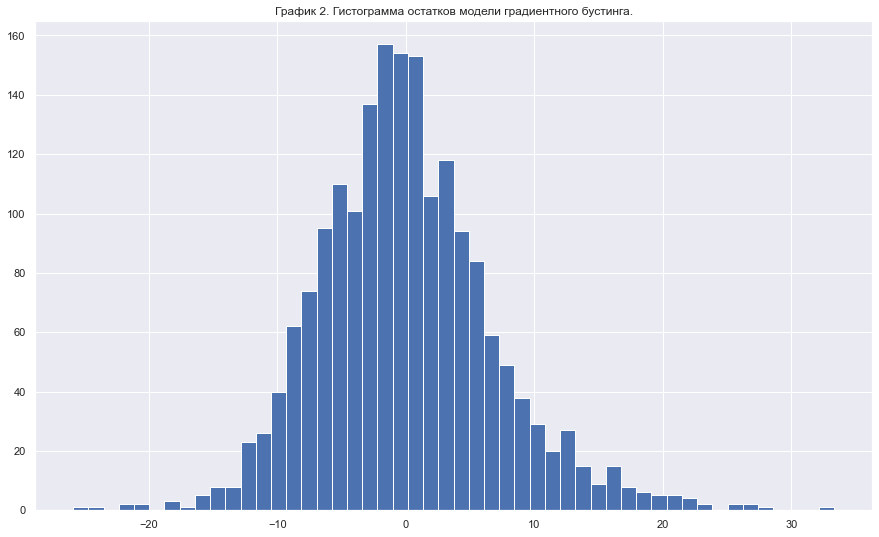

In [102]:
f, ax = plt.subplots(figsize = (15, 9))
train_resids.hist(bins = 50)
plt.title('График 2. Гистограмма остатков модели градиентного бустинга.')
plt.show()

В завершение мы провели оценку модели на тестовой выборке, МАЕ на тесте составляет 6,27. Также мы подготовили анализ важности факторов модели, который приведен на Графике 1 выше.

## Заключение.

В ходе работы над проектом мы получили ценный опыт как в сфере металлургии, так и работы над моделями.

Наиболее существенный вклад в итоговый результат на наш взгляд внесла работа с исходными данными - подготовка признаков, обработка пропусков, а также проверка на мультиколлинеарность и удаление столбцов не добавляющих информации сверх уже имеющейся.

Хотя разработанному плану следовали не вполне строго (например, нумерация и именование разделов не полностью соответствует плану) все шаги предусмотренные планом были последовательно выполнены, поэтому можем констатировать, что отступать от плана не приходилось.

Существенных трудностей в ходе выполнения проекта не возникло.

Ключевые этапы: подготовка сводного датафрейма, включая всю необходимую предобработку исходных данных, исследовательский анализ, а также обучение и тестирование моделей.

Лучшая модель - модель градиентного бустинга XGBRegressor с метрикой МАЕ = 6,27 на тесте.

Благодарим за внимание!